# ConTect: Blockorientierte Detektion von Kondensstreifen aus Satellitenaufnahmen mittels der Hough-Transformation

## 1. Setup
---

### Masken

In [44]:
"""
Definition von unterschiedlich sensitiven Masken
"""

# Maske A (hohe Erkennungsrate, geringere Genauigkeit)
mask_a = {
    'mask': 'a',
    'binary_threshold': 50,
    'max_px_size': 80,
    'sht_threshold': 0.3,
    'ppht_threshold': 3,
    'line_length': 10,
    'line_gap': 10,
    'ratio_threshold': 3
}

# Maske B (Kompromiss zwischen Erkennungsrate und Genauigkeit)
mask_b = {
    'mask': 'b',
    'binary_threshold': 70,
    'max_px_size': 120,
    'sht_threshold': 0.5,
    'ppht_threshold': 5,
    'line_length': 30,
    'line_gap': 5,
    'ratio_threshold': 5
}

# Maske C (geringe Erkennungsrate, höhere Genauigkeit)
mask_c = {
    'mask': 'c',
    'binary_threshold': 90,
    'max_px_size': 200,
    'sht_threshold': 0.9,
    'ppht_threshold': 10,
    'line_length': 50,
    'line_gap': 3,
    'ratio_threshold': 7
}

### Generelle Parameter

In [45]:
"""
Parameter für Pfade, Vorverarbeitung und Klassifikation
"""

import os
import datetime

def _today():
    return datetime.date.today().__str__()

# HDF-Eingabedaten
product_name = 'MODTBGA'
file_path = '../data/granules/MODTBGA/MODTBGA.A2012094.h15v03.006.2015240000438.hdf'
output_dir = os.makedirs('./data/output/' + _today(), exist_ok=True)

# CSV-Dateien mit Fluginformationen
flight_input_dir = '../data/flights/raw'
flight_output_dir = '../data/flights/processed'

# Bänder
BAND = 'BAND'
SUFFIX = '_1'

# Vorverarbeitung
norm_interval = 100
gauss_kernel_size = 5
k = 0.1

# Detektion
method = 'probabilistic' # 'standard'
split_by = 4
connectivity = 2

# Klassifikation
low_threshold = 30
high_threshold = 1000
flight_trail_width = 10

# Maske für diesen Durchlauf
params = mask_b

### Hilfsmethoden

In [46]:
"""
Hilfsmethoden zum Überprüfen und Erstellen von Verzeichnissen
"""

def create_path(path: [str]):
    return os.path.join(*path)

def check_path(path: [str], create: bool) -> str:
    path = create_path(path)
    
    if create:
        os.makedirs(path, exist_ok=True)
        
    if os.path.exists(path):
        return path
    else:
        print(path + ' not found')

In [47]:
"""
Hilfsmethoden für (sehr große) CSV-Dateien und JSON-Dateien
"""

from csv import DictWriter
from json import dump
import pandas as pd
import dask.dataframe as dd
import re
from collections import deque
import time

def write_csv_dict(output_file: str, dict_list: [{}], columns: [str]):
    with open(output_file, 'w', newline='') as output_csv:
        writer = DictWriter(output_csv, fieldnames=columns)
        writer.writeheader()

        for row in dict_list:
            writer.writerow({key: value for key, value in row.items() if key in columns})


def write_json(output_file: str, params):
    with open(output_file, "w") as output_json:
        dump(params, output_json)


def read_csv_pandas(path, dtypes=None):
    return pd.read_csv(path, dtype=dtypes)


def write_csv_pandas(df: pd.DataFrame, path: str, columns=None):
    df.to_csv(path, index=False, columns=columns)
    return os.path.exists(path)


def read_csv_dask(path, dtypes=None, skiprows=None):
    if _is_faulty(path):
        _remove_last_line(path)

    try:
        df = dd.read_csv(path, skiprows=[skiprows], dtype=dtypes)
        df.tail(10)
    except TypeError:
        df = None

    return df


def _is_faulty(path: []):
    is_faulty = False

    with open(path, 'r') as f:
        if not re.match("^[0-9]+$", deque(f, 1)[0].split(',')[0]):
            is_faulty = True

    return is_faulty


def _remove_last_line(path: str):
    last_line_deleted = False

    with open(path, "r+", encoding="utf-8") as file:

        # find end of file
        file.seek(0, os.SEEK_END)

        # skip the last character
        pos = file.tell() - 1

        # search for the newline character (i.e. the last row)
        while pos > 0 and file.read(1) != "\n":
            pos -= 1
            file.seek(pos, os.SEEK_SET)

        # delete the last line
        if pos > 0:
            file.seek(pos, os.SEEK_SET)
            file.truncate()
            last_line_deleted = True

        # wait until operation is finished
        time.sleep(5)

    return last_line_deleted

In [48]:
# Hilfsmethode zum Plotten eines Numpy-Arrays

import numpy as np
import matplotlib.pyplot as plt

def _plot_arr(img: np.array):
    fig, ax = plt.subplots()
    ax.imshow(img)
    ax.set_axis_off()

## 2. Extraktion
---

### Bild- und Metadaten aus den HDF-Dateien

In [49]:
from osgeo import gdal
import re
import pytz

def get_hdf(filepath: str):
    try:
        ds = gdal.Open(filepath)
        return ds
    except FileNotFoundError as e:
        print(e)
        
def get_hdf_meta(filepath: str) -> {}:
    ds = get_hdf(filepath)
    return ds.GetMetadata_Dict()

def get_sds_list(filepath: str) -> []:
    ds = get_hdf(filepath)
    return ds.GetSubDatasets()

def get_sds_path(filepath, band_number, band_keyword, band_suffix):
    path = None

    for sds_path, _ in get_sds_list(filepath):
        name = sds_path.split(':')[-1]
        sds_suffix = re.sub('[^0-9]', '', name.replace(band_keyword, '').replace(band_suffix, ''))

        if name.find(band_keyword) != -1 and int(sds_suffix) == band_number:
            path = sds_path
            break

    return path

def get_sds_array(sds_path: str):
    try:
        sds = get_hdf(sds_path)
        return sds.ReadAsArray()
    except (FileNotFoundError, TypeError) as e:
        print(e)
        


def extract_metadata(filepath: str) -> {}:
    metadata = get_hdf_meta(filepath)
    datetime_format = "%Y-%m-%dT%H:%M:%S.%fZ"
    
    granule = {
               'hdf': filepath,
               'name': filepath.split('/')[-1].replace('.hdf', ''),
               'start': datetime.datetime.strptime(metadata['GRANULEBEGINNINGDATETIME'], 
                                                   datetime_format).astimezone(pytz.UTC),
               'end': datetime.datetime.strptime(metadata['GRANULEENDINGDATETIME'], 
                                                 datetime_format).astimezone(pytz.UTC),
               'west': float(metadata['WESTBOUNDINGCOORDINATE']),
               'east': float(metadata['EASTBOUNDINGCOORDINATE']),
               'north': float(metadata['SOUTHBOUNDINGCOORDINATE']),
               'south': float(metadata['NORTHBOUNDINGCOORDINATE']),
               'shape': (int(metadata['DATACOLUMNS']), int(metadata['DATAROWS'])),
               'h': 'h' + metadata['HORIZONTALTILENUMBER'],
               'v': 'v' + metadata['VERTICALTILENUMBER']
               }
    del metadata
    
    return granule

In [50]:
granule = extract_metadata(file_path)

### Flugdaten

In [51]:
"""
Methoden zur automatischen Extraktion von Flugdaten bzw. Laden der bereits extrahierten Fluginformationen
"""

import pandas as pd

DTYPES = {
    'FLIGHT_ID': int,
    'SEGMENT_NO': int,
    'LATITUDE': np.double,
    'LONGITUDE': np.double,
    'ALTITUDE': np.double,
    'SEGMENT_MONTH': int,
    'SEGMENT_DAY': int,
    'SEGMENT_YEAR': int,
    'SEGMENT_HOUR': int,
    'SEGMENT_MIN': int,
    'SEGMENT_SEC': np.double,
    'EMISSIONS_MODE': np.double,
    'TEMPERATURE': np.double,
    'PRESSURE': np.double,
    'HUMIDITY': np.double,
    'SPEED': np.double,
    'SEGMENT_TIME': object,
    'TRACK_DISTANCE': np.double,
    'THRUST': np.double,
    'WEIGHT': np.double,
    'FUELBURN': np.double,
    'CO': np.double,
    'HC': np.double,
    'NOX': np.double,
    'PMNV': np.double,
    'PMSO': np.double,
    'PMFO': np.double,
    'CO2': np.double,
    'H2O': np.double,
    'SOX': np.double
}

def _processed_filepath(output_dir: str, granule: {}) -> str:    
    starttime = datetime.datetime.strftime(granule['start'], "%Y%m%d_%H%M")
    endtime = datetime.datetime.strftime(granule['end'], "%Y%m%d_%H%M")
    filename = '_'.join([granule['h'], granule['v'], starttime, endtime]) + '.csv'
    return create_path([output_dir, filename])


def _raw_filepath(input_dir, timestamp):
    filename = '_'.join([str(timestamp.month), str(timestamp.day), str(timestamp.year), 'SEGMENT']) + '.csv'
    return create_path([input_dir, filename])


def _filter_by_time_and_position(day_segment_df: pd.DataFrame, south: float, north: float, east: float, west: float,
                                 startdatetime: datetime, enddatetime: datetime):
    lat_min = min(south, north)
    lat_max = max(south, north)
    lon_min = min(west, east)
    lon_max = max(west, east)

    filtered = day_segment_df.loc[(day_segment_df['LATITUDE'] >= lat_min)
                                  & (day_segment_df['LATITUDE'] <= lat_max)
                                  & (day_segment_df['LONGITUDE'] >= lon_min)
                                  & (day_segment_df['LONGITUDE'] <= lon_max)
                                  & (day_segment_df['SEGMENT_HOUR'] >= startdatetime.hour)
                                  & (day_segment_df['SEGMENT_HOUR'] <= enddatetime.hour)
                                  & (day_segment_df['SEGMENT_MIN'] >= startdatetime.minute)
                                  & (day_segment_df['SEGMENT_MIN'] <= enddatetime.minute)
                                  ]
    computed = filtered.compute(scheduler='threads', num_workers=2)
    return computed


def extract_granule_flights(granule: {}):
    processed_filepath = _processed_filepath(flight_output_dir, granule)

    if os.path.exists(processed_filepath):
        processed = read_csv_pandas(processed_filepath, DTYPES)

    else:
        raw_filepath = _raw_filepath(flight_input_dir, granule['start'])
        raw = read_csv_dask(raw_filepath, DTYPES, 1)

        if raw is not None:
            processed = _filter_by_time_and_position(raw, 
                                                     granule['south'], 
                                                     granule['north'],
                                                     granule['east'],
                                                     granule['west'],
                                                     granule['start'], 
                                                     granule['end'])
        else:
            processed = pd.DataFrame(DTYPES.keys())

        write_csv_pandas(processed, processed_filepath)

    granule['flight_count'] = len(processed['FLIGHT_ID'].unique().tolist())
    granule['flight_file_processed'] = processed_filepath

    del processed

    return granule

In [52]:
granule = extract_granule_flights(granule)

## 3. Vorverarbeitung
---

### Contrail Detection Algorithm

In [53]:
"""
Vorverarbeitung mit dem Contrail Detection Algorithm nach Mannstein et al. (1999)
"""

from scipy.ndimage import gaussian_filter
from skimage.exposure import rescale_intensity
from sklearn.preprocessing import normalize


def _normalize(img: np.array, cda_norm_interval: int) -> np.array:
    return normalize(img) * cda_norm_interval


def _invert(img: np.array) -> np.array:
    return img.max() - img


def _scale(img: np.array, cda_norm_interval: int) -> np.array:
    return (img - np.min(img)) / (np.max(img) - np.min(img)) * cda_norm_interval


def _gaussian_filter(img: np.array, kernel_size: int) -> np.array:
    return gaussian_filter(img, sigma=(kernel_size, kernel_size))


def _btd(band_11: np.array, band_12: np.array) -> np.array:
    return band_12 - band_11


def _calc_n(img: np.array, img_m: np.array, img_std: np.array, k: float) -> np.array:
    return (img - img_m) / (img_std + k)


def _rescale_intensity(img: np.array, out_range) -> np.array:
    return rescale_intensity(img, out_range=out_range)


def preprocess_image(granule: {}) -> {}:
    if granule['flight_count'] <= 0:
        return granule

    b11_path = get_sds_path(granule['hdf'], 31, 'BAND', '_1')
    b12_path = get_sds_path(granule['hdf'], 32, 'BAND', '_1')

    b11 = get_sds_array(b11_path)
    b12 = get_sds_array(b12_path)

    # normalize arrays between 0 and 100
    b11_n = _normalize(b11, norm_interval)
    b12_n = _normalize(b12, norm_interval)
    b11_ns = _scale(b11_n, norm_interval)
    b12_ns = _scale(b12_n, norm_interval)

    # calc btd and invert band 12
    td = _btd(b11_ns, b12_ns)
    t5i = _invert(b12_ns)

    # smooth arrays with gaussian 5x5 kernel
    tdm = _gaussian_filter(td, gauss_kernel_size)
    t5m = _gaussian_filter(t5i, gauss_kernel_size)

    # calculate std
    sdtd = np.std(td)
    sdt5 = np.std(t5i)

    # combining std, smoothed and inverted
    nd = _calc_n(td, tdm, sdtd, k)
    n5 = _calc_n(t5i, t5m, sdt5, k)

    granule['cda'] = nd + n5

    del b11, b12, nd, n5, sdtd, sdt5, td, tdm, t5m, t5i

    return granule

In [54]:
granule = preprocess_image(granule)

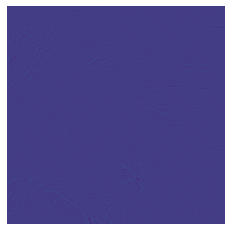

In [55]:
_plot_arr(granule['cda'])

## 4. Detektion

### Bereinigung

In [56]:
"""
Methoden zur Entfernung von kleinen Objekten/Verbinden von Pixelansammlungen
"""

from skimage.morphology import (binary_closing, binary_dilation, closing,
                                remove_small_objects, square)


def close_gaps_binary(arr: np.array) -> np.array:
    return binary_closing(arr)


def filter_small_objects(arr: np.array, max_size: int, is_bool: bool = False) -> np.array:
    if is_bool:
        arr = arr.astype(bool)
    return remove_small_objects(arr, max_size)


def dilate_binary(arr: np.array) -> np.array:
    return binary_dilation(arr)


def threshold_binary(img: np.array, threshold: int) -> np.array:
    return img > np.percentile(img, threshold)


def close_gaps_square(img: np.array, square_size: int) -> np.array:
    return closing(img, square(square_size))

In [57]:
cda = granule['cda']
cda_t = threshold_binary(cda, params['binary_threshold'])
cda_tf = filter_small_objects(cda_t, params['max_px_size'])
cda_tfc = close_gaps_binary(cda_tf)

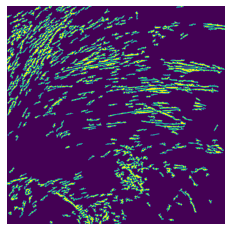

In [58]:
_plot_arr(cda_tfc)

### Aufteilen in Blöcke

In [59]:
def create_block(img: np.array, row: int, column: int, size: int) -> np.array:
    base = np.arange(size)
    return img[base[:, np.newaxis] + row * size, base + column * size]


def split_blocks(img: np.array, split_by: int, block_size: int) -> [np.array]:
    blocks = []
    for row in range(split_by):
        for column in range(split_by):
            blocks.append(create_block(img, row, column, block_size))
    return blocks


def combine_blocks(blocks: [np.array], split_by: int) -> np.array:
    if split_by == 0:
        img = blocks[0]
    else:
        rows = [np.concatenate(blocks[col_num:col_num + split_by], axis=1) for col_num in
                range(0, len(blocks), split_by)]
        img = np.concatenate(rows, axis=0)
    return img

In [60]:
block_size = granule['shape'][0] // split_by
blocks = split_blocks(cda_tfc, split_by, block_size)

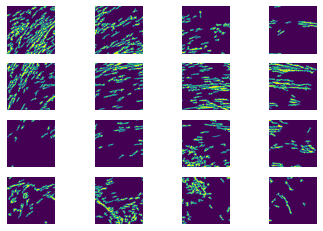

In [61]:
fig, axes = plt.subplots(split_by, split_by)
for block, ax in zip(blocks, axes.flat):
    ax.imshow(block)
    ax.set_axis_off()
plt.show()

### Hough-Transformation

In [62]:
"""
Methoden zum Labeln und Segmentieren von detektierten Kondensstreifen
"""

from skimage.draw import line as sk_line
from skimage.draw import line_aa as sk_line_aa
from skimage.measure import regionprops_table
from skimage.morphology import label


def label_segments(img: np.array) -> np.array:
    return label(img, return_num=False)


def filter_labels(img: np.array, label_list: [int]) -> np.array:
    mask = np.zeros(img.shape, dtype=int)

    for ix, iy in np.ndindex(img.shape):
        if img[ix, iy] in label_list:
            mask[ix, iy] = True
        else:
            mask[ix, iy] = False
    return mask

def _correct_value(val, shape):
    if type(val) in [float("-inf"), float("inf"), float("nan"), float("NaN")] or not val:
        return None

    try:
        val = round(val)
    except (ValueError, OverflowError):
        return None

    if val >= shape:
        val = shape - 1
    if val <= -shape:
        val = -shape + 1
    return int(val)

# TODO: refactor
def get_line_label_intersections(labeled: np.array, line_peaks, shape: (int, int)) -> [int]:
    intersections = []

    for _, angle, dist in zip(*line_peaks):

        if angle == 0.0:
            continue

        y0 = _correct_value(
            (dist - 0 * np.cos(angle) / np.sin(angle)), shape[0])
        y1 = _correct_value(
            (dist - shape[1] * np.cos(angle) / np.sin(angle)), shape[1])
        x0 = 0
        x1 = _correct_value(shape[1], shape[1])

        if y0 is None or y1 is None or x0 is None or x1 is None:
            continue

        line_arr = np.zeros(labeled.shape, dtype=int)
        rr, cc = sk_line(x1, x0, y1, y0)
        line_arr[rr, cc] = 1

        for label_num in range(1, labeled.max()):
            if label_num == 0:
                continue
            mask = labeled == label_num
            masked = line_arr * mask

            if masked.any():
                intersections.append(label_num)

    return list(set(intersections))


def _dimension_ratio(img: np.array) -> float:
    props = regionprops_table(img, properties=(
        'major_axis_length', 'minor_axis_length'))

    if props['major_axis_length'][0] > 0 and props['minor_axis_length'][0] > 0:
        ratio = props['major_axis_length'][0] / props['minor_axis_length'][0]
    else:
        ratio = 0

    return ratio


def get_line_type_segments(labeled: np.array, intersections: [int], ratio_threshold: int) -> [int]:
    line_type_segments = []

    for i_label in intersections:
        mask = labeled == i_label
        mask = mask.astype(np.uint8)
        ratio = _dimension_ratio(mask)

        if ratio and ratio >= ratio_threshold:
            line_type_segments.append(i_label)

    return list(set(line_type_segments))


def line_segment_intersect_prob(labeled: np.array, lines: []) -> [int]:
    intersections = []

    for hline in lines:
        p0, p1 = hline
        x0 = p0[0]
        x1 = p0[1]
        y0 = p1[0]
        y1 = p1[1]

        line_arr = np.zeros(labeled.shape, dtype=int)
        rr, cc = sk_line(x1, x0, y1, y0)
        line_arr[rr, cc] = 1

        for label_num in range(1, labeled.max()):
            if label_num == 0:
                continue
            mask = labeled == label_num
            masked = line_arr * mask

            if masked.any():
                intersections.append(label_num)

    return list(set(intersections))

#### Standard Hough Transformation

In [63]:
"""
Implementierung der SHT
"""

from skimage.transform import (hough_line, hough_line_peaks)

def standard(img: np.array, params: {}) -> np.array:
    tested_angles = np.linspace(-np.pi / 2, np.pi / 2, 360, endpoint=False)
    h, theta, d = hough_line(img, theta=tested_angles)
    line_peaks = hough_line_peaks(
        h, theta, d, threshold=params['sht_threshold'] * h.max())

    labeled = label_segments(img)
    intersect_labels = get_line_label_intersections(
        labeled, line_peaks, img.shape)
    line_type_labels = get_line_type_segments(
        labeled, intersect_labels, params['ratio_threshold'])
    mask = filter_labels(labeled, line_type_labels)

    mask = close_gaps_binary(mask)
    mask = filter_small_objects(mask, params['max_px_size'], True)

    return mask, len(intersect_labels), len(line_type_labels)

#### Progressive Probabilistic Hough Transformation

In [64]:
"""
Implementierung der PPHT
"""

from skimage.transform import probabilistic_hough_line

def probabilistic(img, params):
    lines = probabilistic_hough_line(img, 
                                     threshold=params['ppht_threshold'], 
                                     line_length=params['line_length'],
                                     line_gap=params['line_gap'])
    labeled = label_segments(img)
    intersect_labels = line_segment_intersect_prob(labeled, lines)
    line_type_labels = get_line_type_segments(labeled, 
                                              intersect_labels, 
                                              params['ratio_threshold'])
    mask = filter_labels(labeled, line_type_labels)

    return mask, len(intersect_labels), len(line_type_labels)

In [65]:
if method == 'probabilistic':
    masks, mask_intersection_count, mask_line_type_count = map(list, zip(*[probabilistic(block, params) for block in blocks]))

else:
    masks, mask_intersection_count, mask_line_type_count = map(list, zip(*[standard(block, params) for block in blocks]))

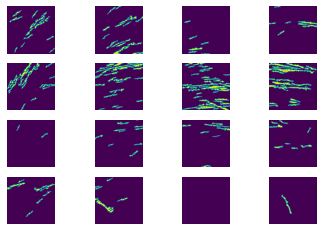

In [66]:
fig, axes = plt.subplots(split_by, split_by)
for mask, ax in zip(masks, axes.flat):
    ax.imshow(mask)
    ax.set_axis_off()
plt.show()

In [67]:
granule['mask'] = combine_blocks(masks, split_by)
granule['intersects'] = mask_intersection_count
granule['line_types'] = mask_line_type_count

del blocks
del masks
del mask

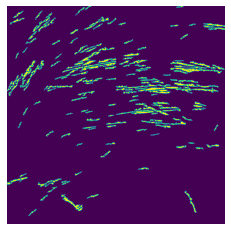

In [68]:
_plot_arr(granule['mask'])

## 5. Metriken

In [69]:
"""
Sammeln von Metriken für die spätere Klassifikation
"""

import numpy as np
from shapely.geometry import LineString

def collect_metrics(granule: {}, flight_trail_width):
    if granule['flight_count'] <= 0:
        return granule

    # contrails
    granule['contrail_pixel'] = granule['mask'].sum()
    granule['contrail_pixel_percent'] = (granule['contrail_pixel'] / (
        (granule['shape'][0] * granule['shape'][1]))) * 100

    # flights
    granule['flight_pixel'] = _flight_pixel(
        granule['flight_file_processed'], flight_trail_width)
    granule['flight_pixel_percent'] = (granule['flight_pixel'] / (
        (granule['shape'][0] * granule['shape'][1]))) * 100

    # intersections
    granule['intersections_per_granule'] = sum(granule['intersects'])
    granule['line_types_per_granule'] = sum(granule['line_types'])

    # ratio between contrails and flights
    granule['deviation'] = granule['contrail_pixel_percent'] - \
        granule['flight_pixel_percent']
    granule['deviation_percent'] = granule['deviation'] / \
        granule['flight_pixel_percent']
    granule['deviation_percent_abs'] = np.abs(
        granule['deviation_percent'])

    return granule


def _flight_pixel(csv_path: str, dilation: float):
    flights = read_csv_pandas(csv_path)

    flight_area = 0

    for flight_id in flights['FLIGHT_ID'].unique():
        flight = flights[flights['FLIGHT_ID'] == flight_id]
        points = list(zip(flight['LATITUDE'], flight['LONGITUDE']))

        if len(points) > 2:
            line = LineString(points)
            dilated = line.buffer(dilation)

            flight_area += dilated.area

    return flight_area

In [70]:
granule = collect_metrics(granule, flight_trail_width)

In [71]:
print('Geschätzte Pixelbedeckung: ' + str(granule['flight_pixel_percent']))
print('Tatsächliche Pixelbedeckung: ' + str(granule['contrail_pixel_percent']))
print('Abweichung: ' + str(granule['deviation_percent']))
print('Abweichung absolut: ' + str(granule['deviation_percent_abs']))
print('Segmente: ' + str(granule['intersections_per_granule']))
print('Linienartige Segmente: '  + str(granule['line_types_per_granule']))
print('Anteil linienartiger Segmente: ' + str(granule['line_types_per_granule'] / granule['intersections_per_granule'] * 100))

Geschätzte Pixelbedeckung: 6.486974789778414
Tatsächliche Pixelbedeckung: 5.5661805555555555
Abweichung: -0.1419450921365939
Abweichung absolut: 0.1419450921365939
Segmente: 310
Linienartige Segmente: 149
Anteil linienartiger Segmente: 48.064516129032256
